In [1]:
# https://platform.olimpiada-ai.ro/problems/66

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision import models

In [2]:
train = pd.read_csv("/kaggle/input/saving-xmas/train.csv")
test = pd.read_csv('/kaggle/input/saving-xmas/test.csv')

train['image_path'] = '/kaggle/input/saving-xmas/' + train['image_path']
test['image_path'] = '/kaggle/input/saving-xmas/' + test['image_path']

train.shape, test.shape

((200, 2), (100, 1))

In [3]:
train.head()

,image_path,number
0,/kaggle/input/saving-xmas/images/image_0214.png,0
1,/kaggle/input/saving-xmas/images/image_0187.png,4
2,/kaggle/input/saving-xmas/images/image_0000.png,0
3,/kaggle/input/saving-xmas/images/image_0262.png,5
4,/kaggle/input/saving-xmas/images/image_0082.png,3


In [4]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, stratify=train['number'], random_state=42, test_size=0.2)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.is_test = is_test
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img = Image.open(self.df['image_path'][idx])
        if self.transform is not None:
            img = self.transform(img)
        if self.is_test:
            return img
            
        label = self.df['number'][idx]
        return img, label

transform_train = v2.Compose([
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
])

transform_else = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_ds = CustomDataset(train, transform=transform_train)
valid_ds = CustomDataset(valid, transform=transform_else)
test_ds = CustomDataset(test, transform=transform_else, is_test=True)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

len(train_loader), len(valid_loader), len(test_loader)

(5, 2, 4)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def custom_metric(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)
    cnt = np.bincount(abs_diff)[:4]
    w = [1, 1, 0.5, 0.25]
    score = 0
    for i, c in enumerate(cnt):
        score += c * w[i]
    return score
    

def train(model, loss_fn, optimizer, train_loader, valid_loader, device, epochs=10, log_rate=1):
    train_losses, valid_losses, valid_metrics = [], [], []
    for epoch in tqdm(range(epochs), desc='Epoch'):
        model.train()
        running_train_loss, i = 0, 0
        for X, y in (pbar := tqdm(train_loader, desc='Train DataLoader', leave=False)):
            X, y = X.to(device), y.float().to(device)
            output = model(X).squeeze()
            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            i += 1
            running_train_loss += loss.item()
            pbar.set_postfix({'loss': f'{running_train_loss/i:.5f}'})

        train_losses.append(running_train_loss/i)
        if (epoch+1)%log_rate==0:
            print(f'Epoch: {epoch+1} | Train Loss: {running_train_loss/i:.5f}')
        
        model.eval()
        running_valid_loss, running_valid_metric, max_valid_metric, i = 0, 0, 0, 0
        for X, y in (pbar := tqdm(valid_loader, desc='Valid DataLoader', leave=False)):
            X, y = X.to(device), y.float().to(device)
            with torch.no_grad():
                output = model(X).squeeze()
                loss = loss_fn(output, y)

            i += 1
            running_valid_loss += loss.item()
            running_valid_metric += custom_metric(y.cpu().numpy().flatten().astype(int), np.round(output.cpu().numpy()).flatten().astype(int))
            max_valid_metric += len(y)
            pbar.set_postfix({'loss': f'{running_valid_loss/i:.5f}', 'metric': f'{running_valid_metric/i:.5f}'})
            
        valid_losses.append(running_valid_loss/i)
        valid_metrics.append(running_valid_metric/i)
        if (epoch+1)%log_rate==0:
            print(f'Valid Loss: {running_valid_loss/i:.5f} | Valid Metric: {running_valid_metric/i:.5f} ({running_valid_metric/max_valid_metric:.5f}%)')
            
    return train_losses, valid_losses, valid_metrics

In [8]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=1)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 217MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
train_losses, valid_losses, valid_metrics = train(model, loss_fn, optimizer, 
                                                  train_loader, valid_loader,
                                                  device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 4.66954


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 3.83153 | Valid Metric: 13.25000 (0.66250%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 3.09007


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 2.41763 | Valid Metric: 15.25000 (0.76250%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 2.38691


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 2.18557 | Valid Metric: 16.25000 (0.81250%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 1.67820


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 1.29249 | Valid Metric: 18.62500 (0.93125%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 1.19070


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 1.23351 | Valid Metric: 17.37500 (0.86875%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.82997


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 1.42745 | Valid Metric: 18.25000 (0.91250%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.76864


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.69380 | Valid Metric: 19.50000 (0.97500%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.93516


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.82667 | Valid Metric: 19.12500 (0.95625%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.52696


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.60679 | Valid Metric: 19.25000 (0.96250%)


Train DataLoader:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.62288


Valid DataLoader:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 0.79231 | Valid Metric: 19.25000 (0.96250%)


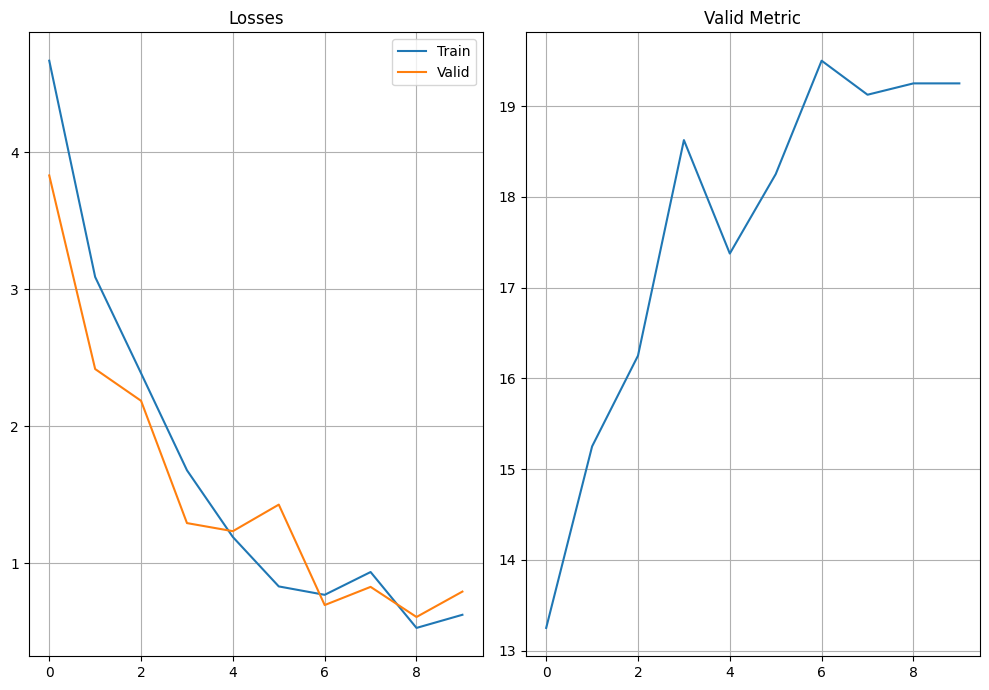

In [11]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(range(len(train_losses)), train_losses, label='Train')
plt.plot(range(len(valid_losses)), valid_losses, label='Valid')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Valid Metric')
plt.plot(range(len(valid_metrics)), valid_metrics)
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
predictions = []

model.eval()
for X in (pbar := tqdm(test_loader, desc='Test DataLoader', leave=True)):
    X = X.to(device)
    with torch.no_grad():
        output = model(X).squeeze()
    preds = np.round(output.cpu().numpy()).flatten().astype(int)
    predictions.append(preds)

predictions = np.concatenate(predictions)

Test DataLoader:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
orig_test = pd.read_csv("/kaggle/input/saving-xmas/test.csv")

subm = pd.DataFrame({
    'image_path': orig_test['image_path'],
    'number': predictions
})

subm.to_csv("submission.csv", index=False)
subm.head()

,image_path,number
0,images/image_0119.png,1
1,images/image_0227.png,0
2,images/image_0160.png,4
3,images/image_0091.png,0
4,images/image_0141.png,5


In [14]:
subm['number'].value_counts()

number
4    26
5    19
3    16
1    15
0    12
2    12
Name: count, dtype: int64